Index(['Tarih', 'temp', 'feelslike', 'dew', 'humidity', 'precip',
       'windspeedmean', 'sealevelpressure', 'cloudcover', 'BarajDoluluk',
       'dakika'],
      dtype='object')
Epoch 1/10, Train Loss: 0.0858, Test Loss: 0.0586


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 2/10, Train Loss: 0.0511, Test Loss: 0.0496
Epoch 3/10, Train Loss: 0.0475, Test Loss: 0.0470
Epoch 4/10, Train Loss: 0.0460, Test Loss: 0.0465
Epoch 5/10, Train Loss: 0.0447, Test Loss: 0.0450
Epoch 6/10, Train Loss: 0.0443, Test Loss: 0.0459
Epoch 7/10, Train Loss: 0.0447, Test Loss: 0.0461
Epoch 8/10, Train Loss: 0.0433, Test Loss: 0.0443
Epoch 9/10, Train Loss: 0.0428, Test Loss: 0.0451
Epoch 10/10, Train Loss: 0.0427, Test Loss: 0.0440
Training Time: 0.94 seconds


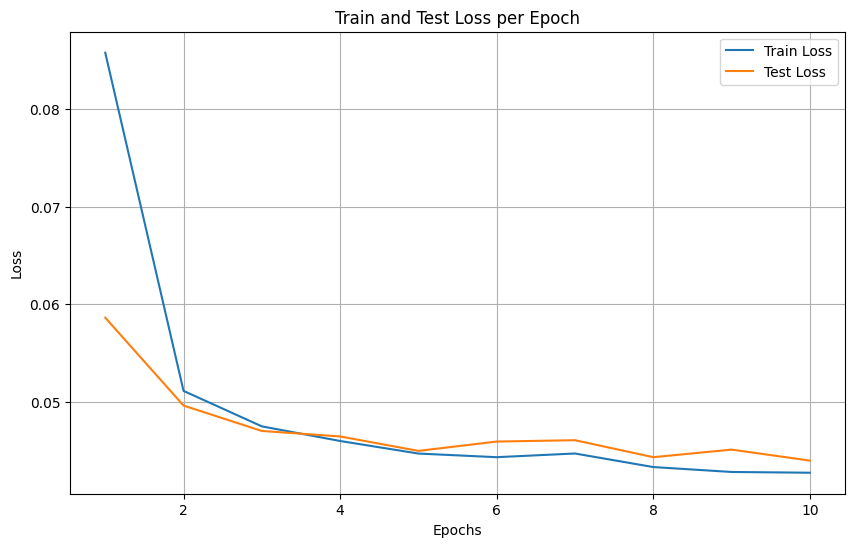

Inference Time: 0.02 seconds
MSE: 0.0440
MAE: 0.1707
RMSE: 0.2098
MAPE: 60.8956%
R-Squared: 0.3724


In [8]:
# Gerekli kütüphaneler
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import time

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

# Verileri yükleme
data = pd.read_excel('büyükçekmecekullan.xlsx')
print(data.columns)
data['Tarih'] = pd.to_datetime(data['Tarih'])  # Tarih sütununu datetime formatına çevirin

# Verilerin ölçeklenmesi
features = ['temp', 'feelslike', 'dew', 'humidity', 'precip',
       'windspeedmean', 'sealevelpressure', 'cloudcover',
       'dakika']
target = 'BarajDoluluk'

scaler = MinMaxScaler()
data[features + [target]] = scaler.fit_transform(data[features + [target]])

# Veri setini giriş ve çıkış olarak ayırma
def create_sequences(data, input_len, pred_len):
    X, y = [], []
    for i in range(len(data) - input_len - pred_len):
        X.append(data[i:i + input_len, :-1])
        y.append(data[i + input_len:i + input_len + pred_len, -1])
    return np.array(X), np.array(y)

input_len = 30  # Geçmiş 365 gün
pred_len = 7    # Tahmin edilen 30 gün
data_array = data[features + [target]].values
X, y = create_sequences(data_array, input_len, pred_len)

# Eğitim ve test setlerini ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Dataset ve DataLoader
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Informer modeli
class Informer(nn.Module):
    def __init__(self, input_size, seq_len, pred_len, d_model, num_heads, num_layers):
        super(Informer, self).__init__()
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=d_model, nhead=num_heads),
            num_layers=num_layers
        )
        self.fc = nn.Linear(seq_len * input_size, pred_len)

    def forward(self, x):
        batch_size, seq_len, input_size = x.size()
        x = x.view(batch_size, seq_len * input_size)  # Flatten for linear layer
        x = self.fc(x)
        return x

# Model oluşturma
input_size = len(features)
d_model = 64
num_heads = 4
num_layers = 2

model = Informer(input_size, seq_len=input_len, pred_len=pred_len,
                 d_model=d_model, num_heads=num_heads, num_layers=num_layers)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Model eğitimi
epochs = 10
train_losses = []
test_losses = []
start_time = time.time()

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader))

    # Test kayıbı hesaplama
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            output = model(X_batch)
            loss = criterion(output, y_batch)
            test_loss += loss.item()
    test_losses.append(test_loss / len(test_loader))

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")

training_time = time.time() - start_time
print(f"Training Time: {training_time:.2f} seconds")

# Küyup grafikleri
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Loss per Epoch')
plt.legend()
plt.grid()
plt.show()

# Test etme ve çıkarım süreleri
model.eval()
y_true = []
y_pred = []
inference_start_time = time.time()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        output = model(X_batch)
        y_true.extend(y_batch.numpy().flatten())
        y_pred.extend(output.numpy().flatten())
inference_time = time.time() - inference_start_time
print(f"Inference Time: {inference_time:.2f} seconds")

# Performans metrikleri
y_true = np.array(y_true)
y_pred = np.array(y_pred)

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
r2 = r2_score(y_true, y_pred)

print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4f}%")
print(f"R-Squared: {r2:.4f}")
